# 05-01 검증 세트를 나누고 전처리 과정을 배웁니다.

In [90]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


### 1. 로지스틱 회귀 모델을 사용한 경우

In [91]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

### 2. 하이퍼파라미터에 서포트 벡터 머신 (hinge)을 사용한 경우

In [92]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

### 테스트 세트로 모델을 튜닝하면...
- 정작 모델을 최종적으로 다 만들고나서 실전에 투입했을 때 제대로 된 성능을 발휘할 수 없다.
  - 테스트 세트를 반복적으로 사용함으로써 모델이 테스트 세트를 훈련하는 결과를 낳는다.
  - '테스트 세트의 정보가 모델에 새어 나갔다'

### 그렇다면
- 가능한한 테스트 세트를 사용하지 않고 최종적으로 한두번만 테스트 세트를 사용해야한다.
- => 검증세트를 준비한다.

# 검증 세트를 준비합니다.
- 검증 세트를 이용하여 '하이퍼 파라미터'를 튜닝한다.
- best 모델을 찾은 후
- 테스트 세트로 성능을 추정한다.

In [93]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

# 검증세트 준비
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [94]:
# 훈련세트, 검증세트, 테스트 세트의 각각 개수
print('전체 입력 개수 = ', len(x))
print('훈련 세트 개수 = ',len(x_train), ', 비율 = ', len(x_train)/len(x)*100)
print('검증 세트 개수 = ', len(x_val), ', 비율 = ', len(x_val)/len(x)*100)
print('테스트 세트 개수 = ', len(x_test), ', 비율 = ', len(x_test)/len(x)*100)

전체 입력 개수 =  569
훈련 세트 개수 =  364 , 비율 =  63.971880492091394
검증 세트 개수 =  91 , 비율 =  15.992970123022848
테스트 세트 개수 =  114 , 비율 =  20.035149384885763


# 데이터 전처리와 특성의 스케일
$w_i = w_i - \frac{∂L}{∂w_i} = w_i + (y-a)x_i$
- 데이터 간의 스케일이 다를 경우
  - 가중치 업데이트에 많은 영향을 준다.
  - 스케일이 작은 경우 -> 가중치 업데이트가 더디고
  - 스케일이 큰 경우 -> 가중치 업데이트가 크게 된다.

['mean perimeter' 'mean area']


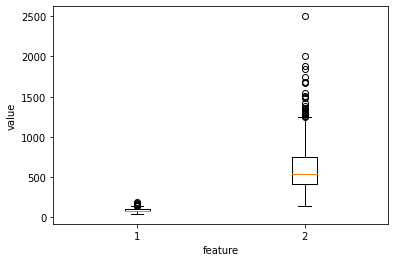

In [95]:
import matplotlib.pyplot as plt
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

### 스케일이 다른 특성의 가중치 변화를 확인해보자
- 가중치를 기록할 변수와 학습률 파라미터 추가
- 학습률 : 가중치 업데이트 양을 조절하는 파라미터

In [96]:
# 클래스 정의
# 스케일이 다른 경우의 가중치 변화를 확인하기 위한 코드
import numpy as np
class SingleLayer:
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []                    # 손실을 저장하는 리스트
        self.w_history = []                                                       # 가중치를 기록하기 위한 변수
        self.lr = learning_rate                                                   # 학습률
    
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b     # 직선의 방정식을 계산
        # z = w1*x1 + w2*x2 ''' wn*xn + b
        return z
    
    def backprop(self, x, err):
        # 가중치와 절편에 대한 그레이디언트를 계산, 반환
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    # 확률적 경사하강법을 적용한 훈련법
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])        # 가중치를 초기화 합니다.
        self.b = 0                          # 절편을 초기화 합니다.
        self.w_history.append(self.w.copy())                                      # 가중치를 기록합니다.
        np.random.seed(42)                                                        # 랜덤시드 지정
        for i in range(epochs):             # epochs만큼 반복합니다.
            loss = 0                        # 손실을 0으로 초기화합니다.
            indexes = np.random.permutation(np.arange(len(x))) # 확률적 경사하강법을 적용하기 위한 인덱스 섞기
            for i in indexes:
                z = self.forpass(x[i])       # 정방향 계산
                a = self.activiation(z)     # 활성화 함수 적용
                err = -(y[i] - a)            # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= self.lr * w_grad                                                  # 가중치 업데이트, 학습률 반영
                self.b -= b_grad            # 절편 업데이트

                self.w_history.append(self.w.copy())                                        # 가중치를 기록합니다.
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
    
    def activiation(self, z):
        z = np.clip(z, -100, None)          # 안전한 np.exp() 계산을 위한 clip함수
        a = 1 / (1 + np.exp(-z))            # 시그모이드 계산
        return a
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]    # 선형 함수 적용
        return np.array(z) > 0                  # 계단 함수 적용
    
    def score(self, x, y):                      # 성능을 보여주는 메서드
        return np.mean(self.predict(x) == y)  

In [97]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

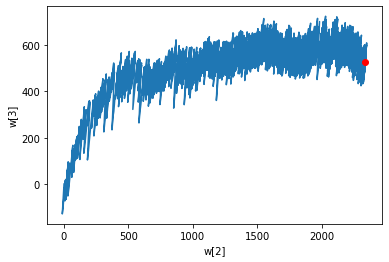

In [98]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()


### 위의 결과
- w[2]는 변화가 완만하다
- 반면 w[3]는 변화가 크다

### 결론
- 스케일 조정이 필요하다

# 스케일을 조정해 모델을 훈련합니다.
- 표준화 : $z = \frac{x-μ}{s}$, $s = \sqrt{\frac{1}{m}\sum\limits_{i=0}^{m}(x_i - \mu)^2}$

In [99]:
train_mean = np.mean(x_train, axis=0)   # train_mean = u
train_std = np.std(x_train, axis=0)     # train_std = s
x_train_scaled = (x_train - train_mean) / train_std   # x_train_scaled = z

In [100]:
# layer2 새로 생성 및 스케일된 데이터로 훈련
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

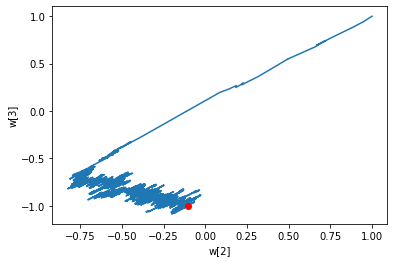

In [101]:
# w2, w3 변화 그래프 확인
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()


# 검증 세트로 모델 성능 평가하기

In [102]:
layer2.score(x_val, y_val)

0.37362637362637363

### 왜 성능이 안 좋은가?
- x_val 검증 데이터 셋은 스케일 조정을 하지 않았기 때문이다.

## x_val도 스케일을 조정합니다.

In [103]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

In [104]:
# 스케일된 검증 세트로 다시 성능 평가
layer2.score(x_val_scaled, y_val)

0.967032967032967

# 하지만 함정이 존재한다...
## 원본 훈련 세트와 검증 세트의 산점도 VS 스케일된 훈련 세트와 스케일된 검증 세트의 산점도

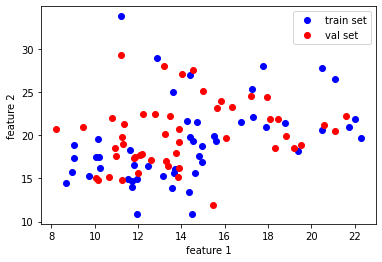

In [105]:
# 1. 원본 훈련세트 + 검증 세트의 산점도
import matplotlib.pyplot as plt
plt.plot(x_train[:50, 0], x_train[:50,1], 'bo') # 원본 훈련 세트 표시 (블루)
plt.plot(x_val[:50, 0], x_val[:50,1], 'ro') # 원본 검증 세트 표시 (레드)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val set'])
plt.show()


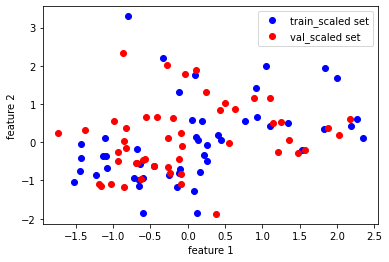

In [106]:
# 2. 스케일된 훈련 세트와 스케일된 검증 세트의 산점도
import matplotlib.pyplot as plt
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1], 'bo') # 스케일된 훈련 세트 표시 (블루)
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro') # 스케일된 검증 세트 표시 (레드)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train_scaled set', 'val_scaled set'])
plt.show()


### 어느부분이?
- (feature1, feature2) = (0.0, 1.5) 부분, (1.0, 1.2) 부분에서 전처리된(스케일된) 점(데이터)이 벌어져있음을 확인할 수 있다.

### 왜?
- 훈련 데이터 셋을 표준화할 때 훈련 데이터 셋의 평균, 표준편차를 사용했고
- 검증 데이터 셋을 표준화할 때 검증 데이터 셋의 평균, 표준편차를 사용했기 때문이다.
- 즉, 서로 다른 평균, 표준편차로 표준화를 수행했기에 이러한 결과가 나타난 것이다.

### 어떻게 처리할까?
- 검증 데이터 셋을 표준화 할 때 훈련 데이터 셋의 평균, 표준편차를 사용한다.

## 올바르게 검증 세트 전처리하기

In [107]:
x_val_scaled = (x_val - train_mean) / train_std

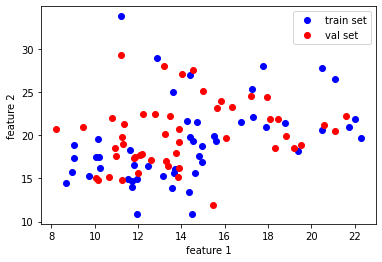

In [108]:
# 1. 원본 훈련세트 + 검증 세트의 산점도
import matplotlib.pyplot as plt
plt.plot(x_train[:50, 0], x_train[:50,1], 'bo') # 원본 훈련 세트 표시 (블루)
plt.plot(x_val[:50, 0], x_val[:50,1], 'ro') # 원본 검증 세트 표시 (레드)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val set'])
plt.show()


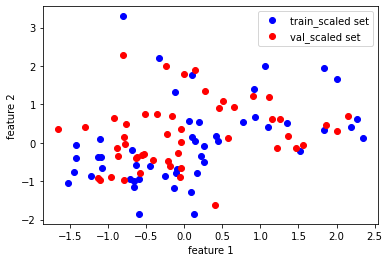

In [109]:
# 2. 스케일된 훈련 세트와 스케일된 검증 세트의 산점도 (훈련 데이터 셋의 평균과 표준편차로 스케일)
import matplotlib.pyplot as plt
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1], 'bo') # 스케일된 훈련 세트 표시 (블루)
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro') # 스케일된 검증 세트 표시 (레드)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train_scaled set', 'val_scaled set'])
plt.show()


## 테스트 세트 또한 '훈련 데이터 세트의 평균과 표준편차'를 이용하여 스케일을 조정해야한다.


In [110]:
x_test_scaled = (x_test - train_mean) / train_std

# 올바르게 전처리된 데이터로 훈련, 검증, 테스트 해보기

In [111]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train)

# 검증 데이터로 성능 검사
layer3.score(x_val_scaled, y_val)

0.967032967032967

In [112]:
# 테스트 데이터로 성능 검사
layer3.score(x_test_scaled, y_test)

0.9824561403508771